In [1]:
!pip install matplotlib
!pip install scikit-image

  Using cached matplotlib-3.2.1-cp36-cp36m-manylinux1_x86_64.whl (12.4 MB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached kiwisolver-1.2.0-cp36-cp36m-manylinux1_x86_64.whl (88 kB)
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
  Using cached scikit_image-0.17.2-cp36-cp36m-manylinux1_x86_64.whl (12.4 MB)
  Using cached imageio-2.8.0-py3-none-any.whl (3.3 MB)
  Using cached networkx-2.4-py3-none-any.whl (1.6 MB)
  Using cached PyWavelets-1.1.1-cp36-cp36m-manylinux1_x86_64.whl (4.4 MB)
  Using cached tifffile-2020.5.30-py3-none-any.whl (133 kB)
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
!pip install plotly

  Using cached plotly-4.8.1-py2.py3-none-any.whl (11.5 MB)
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
PATH = "./shipdetection/"
TRAIN_PATH = PATH + "train_v2/"
TEST_PATH = PATH + "test_v2/"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import os

# from kmader
import gc; gc.enable() # memory is tight

In [4]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    if type(mask_rle) != str:
        return np.zeros(shape)
    else:
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1
        return img.reshape(shape).T  # Needed to align to RLE direction


masks = pd.read_csv(PATH + "train_ship_segmentations_v2.csv")

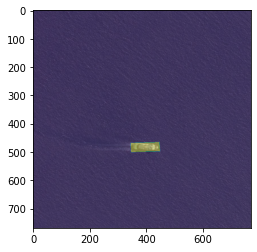

In [5]:
#%% check decode
test_mask = masks.loc[masks['ImageId'] == '000155de5.jpg']['EncodedPixels']
decode = rle_decode(test_mask.iloc[0])
test_img = skimage.io.imread(PATH + 'train_v2/000155de5.jpg')
plt.imshow(test_img)
plt.imshow(decode, alpha = 0.4)

In [5]:
#%% MERGE IMAGE LAYERS WITH MULTIPLE SHIPS


masks['count'] = masks.groupby('ImageId')['EncodedPixels'].transform('count')
masks.set_index('ImageId', inplace = True)
mu = masks[masks['count'] <= 1]
mm = masks[masks['count'] > 1]
n = 0 
for mult in mm.index.unique():
    if n % 100 == 0 : print(n)
    combined = np.zeros((768, 768))
    dfm = mm.loc[mult,:]
    for i, row in dfm.iterrows():
        d = rle_decode(row['EncodedPixels'])
        combined = np.maximum(combined, d)
    new_row = row
    new_row['EncodedPixels'] = rle_encode(combined)
    mu = mu.append(new_row)
    n += 1

mu.reset_index(inplace = True)    
m0 = mu[mu['count'] == 0].iloc[0,:]
m1 = mu[mu['count'] == 1].iloc[0,:]
m2 = mu[mu['count'] == 2].iloc[0,:]
m5 = mu[mu['count'] == 5].iloc[0,:]

m0_img = skimage.io.imread(TRAIN_PATH + m0['ImageId'])
m1_img = skimage.io.imread(TRAIN_PATH + m1['ImageId'])
m2_img = skimage.io.imread(TRAIN_PATH + m2['ImageId'])
m5_img = skimage.io.imread(TRAIN_PATH + m5['ImageId'])

from skimage.util import montage

# montage_img = montage([m0_img, m1_img, m2_img, m5_img])
# plt.imshow(montage_img)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
plt.tight_layout()

ax1.imshow(m0_img)
ax1.imshow(rle_decode(m0['EncodedPixels']), alpha = 0.5)

ax2.imshow(m1_img)
ax2.imshow(rle_decode(m1['EncodedPixels']), alpha = 0.5)

ax3.imshow(m2_img)
ax3.imshow(rle_decode(m2['EncodedPixels']), alpha = 0.5)

ax4.imshow(m5_img)
ax4.imshow(rle_decode(m5['EncodedPixels']), alpha = 0.5)

0
100
200
300
400
500


KeyboardInterrupt: 

In [ ]:
# remove corrupted files

mu['file_size_kb'] = mu['ImageId'].map(lambda c_img_id: 
                                        os.stat(os.path.join(PATH+'train_v2/', 
                                        c_img_id)).st_size/1024)
mu = mu[mu['file_size_kb']>50] # keep only 50kb files

# SAVE HERE!


In [6]:
#mu.to_csv('df_train_processed.csv')
mu2 = pd.read_csv('df_train_processed.csv')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


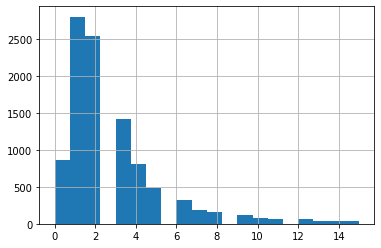

In [7]:
#%% SAMPLE    


from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(mu2, test_size = 0.5, shuffle=True, random_state = 51)

#df_train['count'].hist()

weights = [0.001,0.02,0.1,4,5,6,7,8,9,10,11,12,13,14,15,16]

df_train['weights'] = df_train['count'].map(lambda c : weights[c])

df_train['freq'] = df_train.groupby('count')['count'].transform('count')

df_sample = df_train.sample(n = 10000, weights = df_train['weights'], random_state = 17)
df_sample_test = df_test.sample(n = 10000, random_state = 24)

df_sample['count'].hist(bins=20)

In [8]:
#%% create simple generator

def image_gen(df, show = False, print_name = False):
    images = list(df['ImageId'])
    masks = list(df['EncodedPixels'])
    i = 0
    while i < len(images):
        if print_name:
            print(images[i])
        img = skimage.io.imread(TRAIN_PATH + images[i])
        mask = np.reshape(rle_decode(masks[i]),(768,768,1))
        if show == True:
            plt.imshow(img)
            plt.imshow(mask, alpha = 0.4)
        yield (np.array([img/255]), np.array([mask]))
        i += 1
        
def image_gen_batch(df, batch_size = 1):
    images = np.array(df['ImageId'])
    masks = np.array(df['EncodedPixels'])
    ind = np.arange(len(images))
    np.random.shuffle(ind)
    images = images[ind]
    masks = masks[ind]
    i = 0
    while True:
        batch_img = []
        batch_mask = []
        for x in np.arange(batch_size):
            if i == len(images):
                # loop to beginning and re-shuffle
                i = 0
                np.random.shuffle(ind)
                images = images[ind]
                masks = masks[ind]
            batch_img.append(skimage.io.imread(TRAIN_PATH + images[i])/255.0)
            batch_mask.append(np.reshape(rle_decode(masks[i]),(768,768,1)))
            i += 1
        #img = skimage.io.imread(TRAIN_PATH + images[i])
        #mask = np.reshape(rle_decode(masks[i]),(768,768,1))
        yield (np.array(batch_img), np.array(batch_mask))
        #i += 1
        
        

(4, 768, 768, 3) (4, 768, 768, 1)


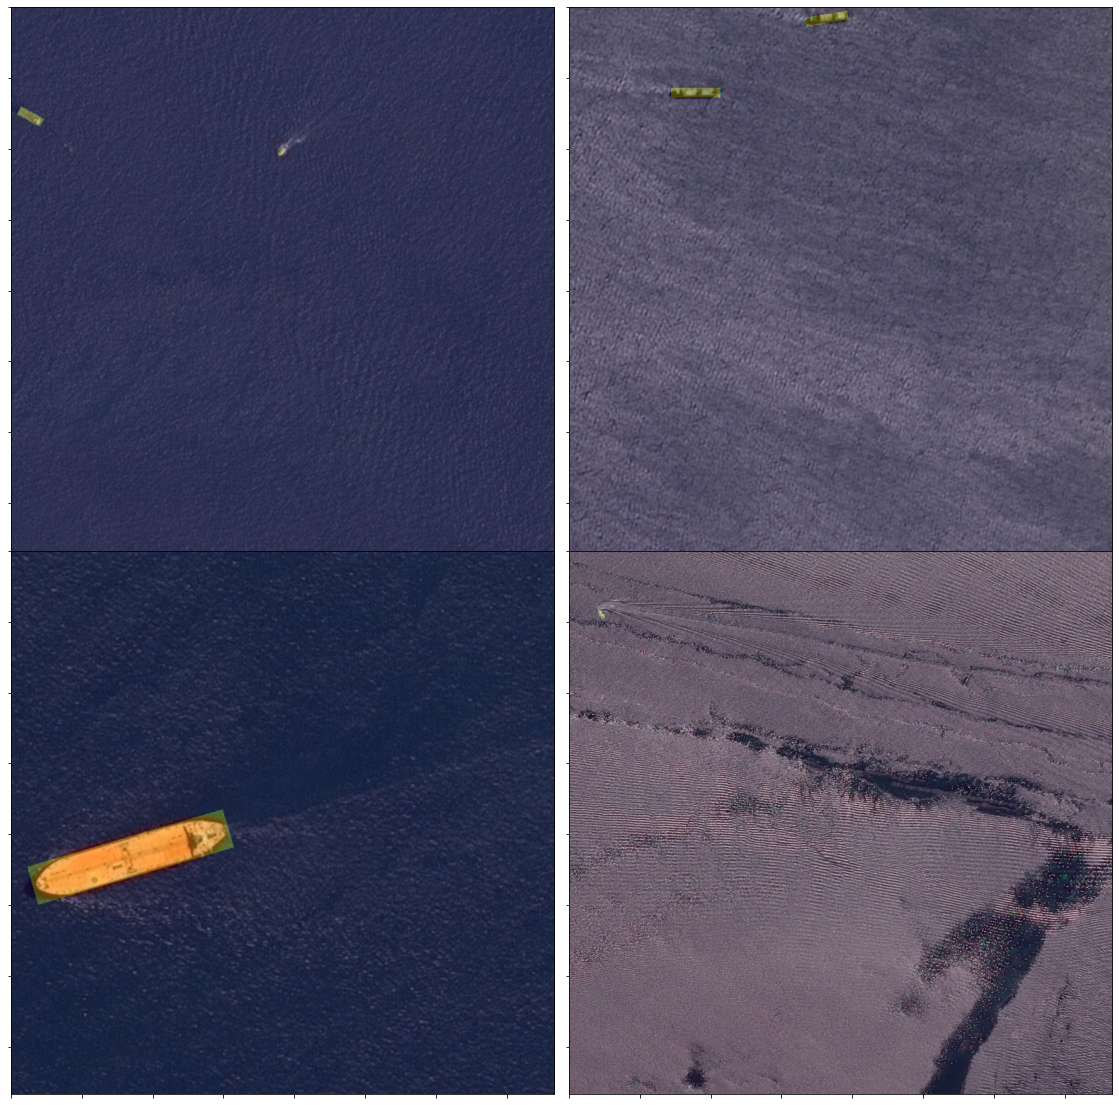

In [9]:
train_gen = image_gen_batch(df_sample, batch_size = 4)
X_train, y_train = next(train_gen)
print(np.shape(X_train), np.shape(y_train))

# revise this with more concise and generalizable code
# https://theailearner.com/2019/07/06/imagedatagenerator-flow-method/

def plot_img_batch(img, mask):
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize = (20,20))
    plt.subplots_adjust(wspace=0, hspace=0)
    ax1.imshow(img[0])
    ax1.imshow(np.reshape(mask[0],(768,768)), alpha = 0.3)
    ax1.set_yticklabels([])
    ax1.set_xticklabels([])

    ax2.imshow(img[1])
    ax2.imshow(np.reshape(mask[1],(768,768)), alpha = 0.3)
    ax2.set_yticklabels([])
    ax2.set_xticklabels([])

    ax3.imshow(img[2])
    ax3.imshow(np.reshape(mask[2],(768,768)), alpha = 0.3)
    ax3.set_yticklabels([])
    ax3.set_xticklabels([])

    ax4.imshow(img[3])
    ax4.imshow(np.reshape(mask[3],(768,768)), alpha = 0.3)
    ax4.set_yticklabels([])
    ax4.set_xticklabels([])
    
def plot_img_batch2(img, mask, nrows = 1, ncols = 1):
    fig = plt.figure(figsize = (20,20))
    plt.subplots_adjust(wspace=0, hspace=0)
    for i in np.arange(nrows*ncols):
        ax = plt.subplot(nrows, ncols, i+1)
        ax.imshow(img[i])
        ax.imshow(np.reshape(mask[i],(768,768)), alpha = 0.3)
        ax.set_yticklabels([])
        ax.set_xticklabels([])

plot_img_batch(X_train,y_train)


test_gen = image_gen_batch(df_test[df_test['count']>3], batch_size = 4)
X_test, y_test = next(test_gen)

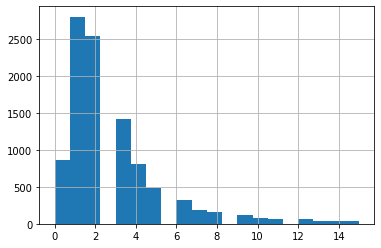

In [10]:
df_sample['count'].hist(bins=20)

Using TensorFlow backend.


(12, 768, 768, 3)
(12, 768, 768, 1)


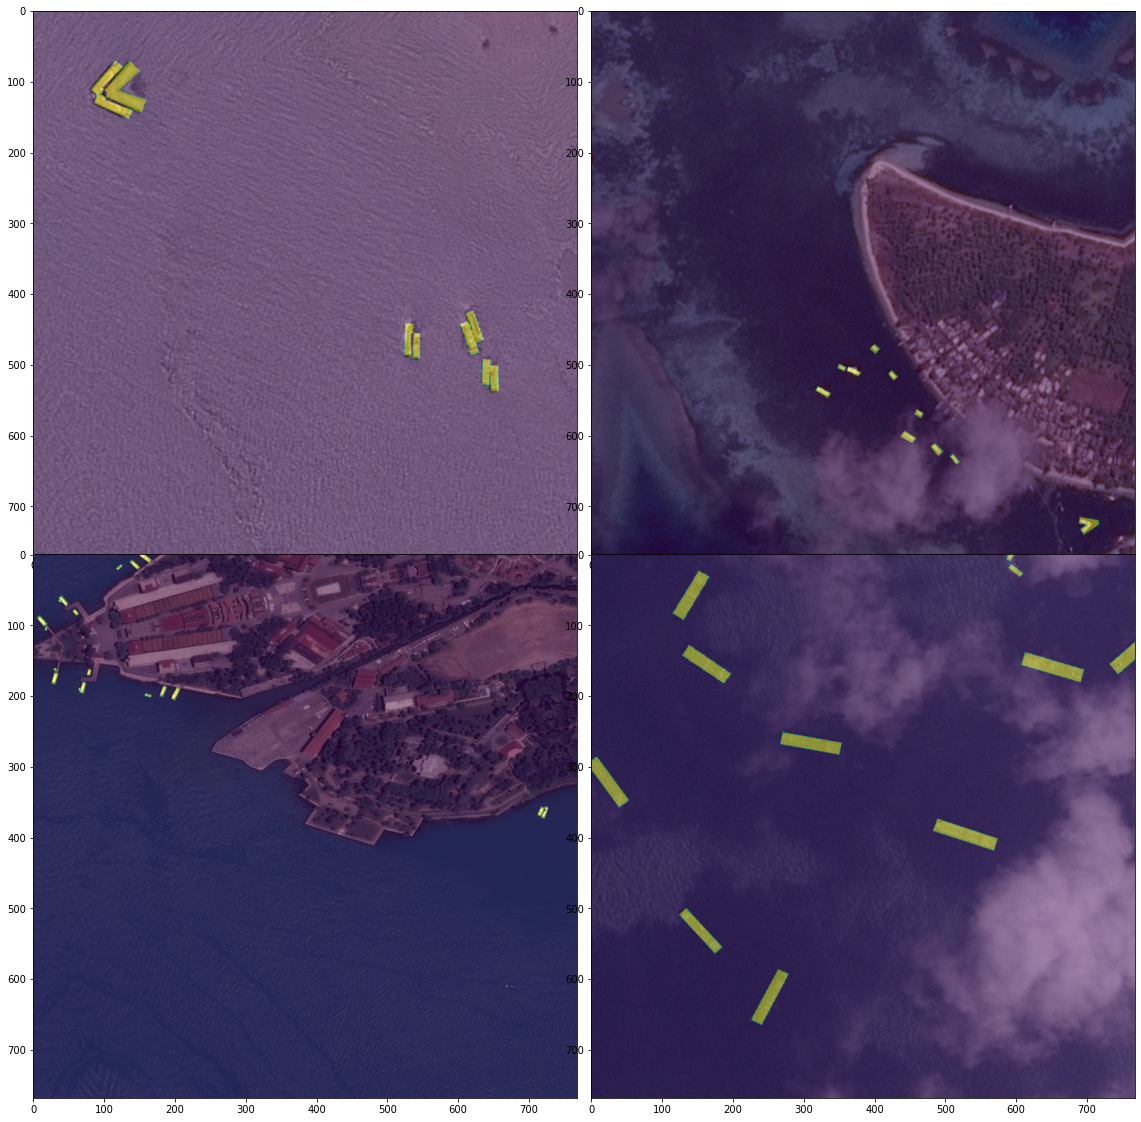

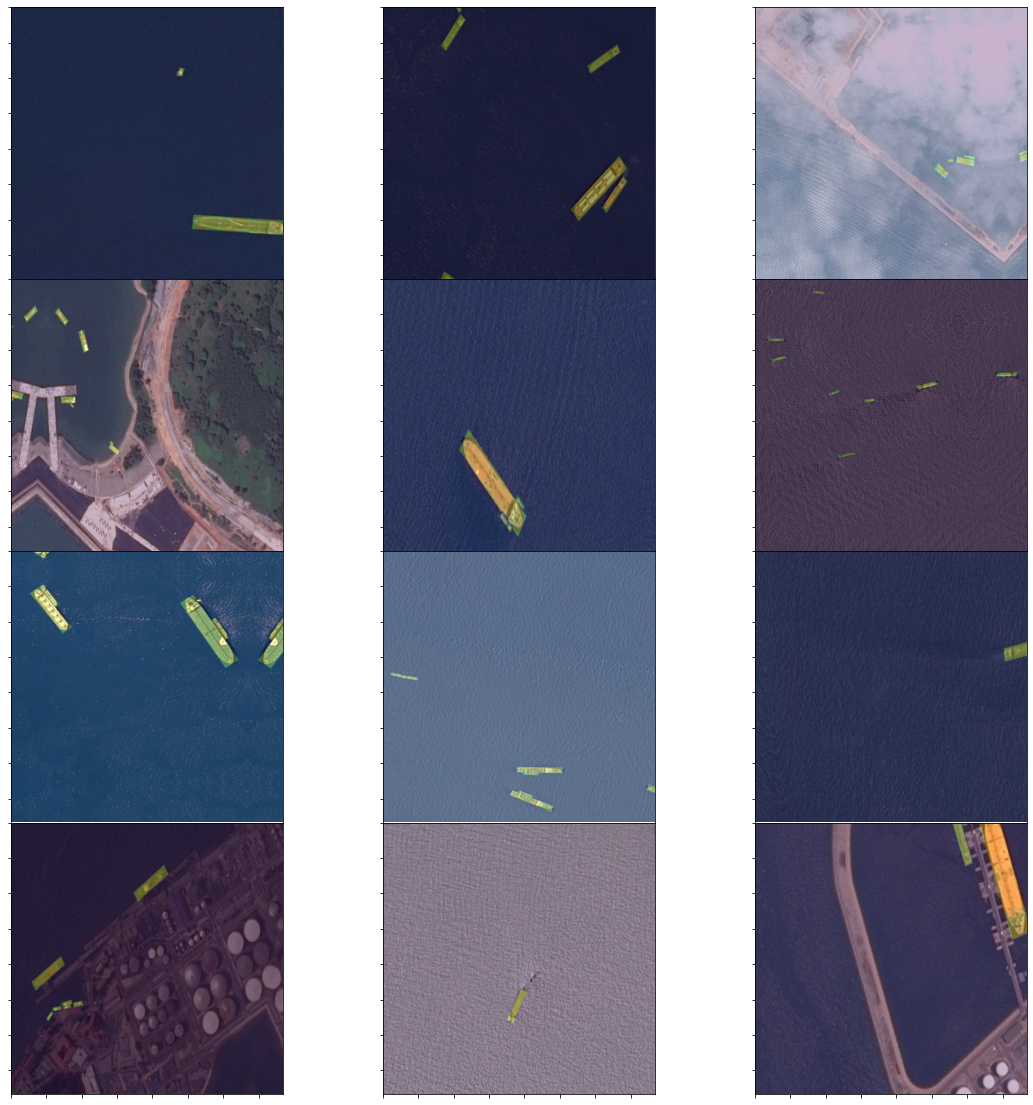

In [11]:
#%% add augmentation

from keras.preprocessing.image import ImageDataGenerator

dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 15, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.5, 1.5],  
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',
                  data_format = 'channels_last',
                  brightness_range = [0.5, 1.5])

im_gen = ImageDataGenerator(**dg_args)

dg_args.pop('brightness_range')
mask_gen = ImageDataGenerator(**dg_args)

def aug_gen(in_gen):
    seed = 57
    for in_x, in_y in in_gen:
        #seed = 5#np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = im_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=False)
        g_y = mask_gen.flow(in_y, 
                             batch_size = in_y.shape[0], 
                             seed = seed, 
                             shuffle=False)
        yield next(g_x)/255.0, next(g_y)
        
def aug_gen2(in_gen):
    seed = np.random.choice(range(9999))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        img_aug = []
        mask_aug = []
        for i in np.arange(np.shape(in_x)[0]):
            seed = np.random.choice(range(9999))
            # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
            g_x = im_gen.flow(255.0*np.array([in_x[i]]), 
                                 batch_size = 1, 
                                 seed = seed, 
                                 shuffle=True)
            g_y = mask_gen.flow(np.array([in_y[i]]), 
                                 batch_size = 1, 
                                 seed = seed, 
                                 shuffle=True)
            img_aug.append(next(g_x)/255.0)
            mask_aug.append(next(g_y))
            #img_aug = np.concatenate(img_aug, next(g_x)/255.0)
            #mask_aug = np.concatenate(mask_aug, next(g_y))
        yield np.array(img_aug)[:,0,:,:,:], np.array(mask_aug)[:,0,:,:,:]
        

# img_gen2 doesn't have brightness augmentation
im_gen2 = ImageDataGenerator(**dg_args)
     
def aug_gen3(in_gen):
    seed = 57
    for in_x, in_y in in_gen:
        #seed = 5#np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        print("in_x: ", np.shape(in_x))
        g = im_gen2.flow(255*in_x,
                              y = in_y,
                              batch_size = 4, 
                              seed = seed, 
                              shuffle=False)
        g_x, g_y = next(g)
        yield g_x/255.0, g_y
        


        

    
test_aug = aug_gen(image_gen(df_sample[df_sample['count'] > 5]))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (20,20))

#plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

tax1, tay1 = next(test_aug)
ax1.imshow(tax1[0])
ax1.imshow(np.reshape(tay1[0], (768,768)), alpha = 0.5)

tax2, tay2 = next(test_aug)
ax2.imshow(tax2[0])
ax2.imshow(np.reshape(tay2[0], (768,768)), alpha = 0.5)

tax3, tay3 = next(test_aug)
ax3.imshow(tax3[0])
ax3.imshow(np.reshape(tay3[0], (768,768)), alpha = 0.5)

tax4, tay4 = next(test_aug)
ax4.imshow(tax4[0])
ax4.imshow(np.reshape(tay4[0], (768,768)), alpha = 0.5)


test_aug_batch = aug_gen2(image_gen_batch(df_sample[df_sample['count'] > 2], batch_size = 12))

X_train_aug, y_train_aug = next(test_aug_batch)

print(np.shape(X_train_aug))
print(np.shape(y_train_aug))

plot_img_batch2(X_train_aug, y_train_aug, nrows = 4, ncols = 3)
    
        
# val_datagen = ImageDataGenerator(rescale=1./255)


In [12]:
gc.collect()

29892

In [13]:
#%% create model
#https://towardsdatascience.com/a-keras-pipeline-for-image-segmentation-part-1-6515a421157d
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

import model9
#model6.reload(unet)

#in_size = (1,768,768,3)
m = model9.unet(input_size = np.shape(X_train)[1:])
#opt = Adam(lr=1E-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08)


/root/model9.py:77: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv10)


In [ ]:
m.summary()

In [ ]:
#BATCH_SIZE = 1

#weights_path = PATH

'''
model 4: epochs =  5
model 5: epochs = 20
    early stop after 11 epochs (accidentally overwritted by model 6)
model 6: uses model5, changed size of conv layers, changed epochs back to 5
    decent results, doesn't look as blurry as model 4 & 5
    shows more detail
    runs faster with fewer filters
model 7: uses model 7, which adds gaussian noise and batch normalization
    NOTE: errors found in model5, need to adjust number of filters
    need to try batch normalization and gaussian blur with model2
    looks like dice_coeff is still improving with epochs, try increasing epochs
model 8: epochs = 20
    good result
model 9: use model 8 (basically model2 with batch norm and gauss), 20 epochs
    looked like total shit
model 10: uses model9, fixed errors in number of filters
model 11: uses a batch_size of 32, 300 steps, 20 epochs
    returns results of almost no ships identified
    early stop after 13 epochs
    found typo in image_aug2: capped the output at 4
model 12: batch_size of 1, steps 100, epochs 5
    intended to try to get some result
    is batching the error?
model 13: batch_size 32, epochs 1, steps 200
    works decent
model 14: fucking ran out of memory in epoch 4
    steps = 300, epochs = 5, batch_size = 32
    checkpoints show no data
model 15: 1 epoch, 300 steps, batch_size 32
    checked load from checkpoints and model: all good!
model 16: batch size 16, steps 200, epochs 5
    all images are blank!
model 17: steps 200 epochs 5 batch_size 32
    got all fucked up because aws logged me out
model 18: steps = 500, batch_size = 20, epochs = 20
    added random shuffling
model 19: added random shuffling, random state to sampling, adjusted sampling weights
    deleted files < 50 kb
    saved pre-process df for faster loading
    steps 500. epochs 3. batch_size 20
    added sampling to training dataset
    PROBABLY THE BEST ONE YET 
    
'''

v = 19

checkpoint = ModelCheckpoint("checkpoints_v%d.out" % v, monitor='val_dice_coef', 
                             verbose=1, save_best_only=True, mode='max')

csv_logger = CSVLogger("log_v%d.out" % v, append=True, separator=';')

earlystopping = EarlyStopping(monitor = 'val_dice_coef', verbose = 1,
                              min_delta = 0.01, patience = 10, mode = 'max')

callbacks_list = [checkpoint, csv_logger, earlystopping]

STEPS = 500
EPOCHS = 3
BATCH_SIZE = 20

# REMEMBER TO GO BACK AND RUN V2 WITH df_sample
results = m.fit_generator(aug_gen2(image_gen_batch(df_sample, batch_size = BATCH_SIZE)),
                          epochs = EPOCHS, 
                          steps_per_epoch = STEPS,
                          validation_data = image_gen_batch(df_sample_test, batch_size = BATCH_SIZE), 
                          validation_steps = STEPS,
                          callbacks = callbacks_list,
                          workers = 1)
m.save('Model_v%d.h5' % v)

def write_hist(hist, filename):
    f = open(filename, 'w')
    for x in hist.keys():
        vals = str(hist[x]).replace('[','').replace(']','')
        f.write(x + ',' + vals + '\n')
    f.close()
    
write_hist(results.history,"results%d_history.csv" % v)

In [14]:
def show_predictions(model, n_pred, test_gen):
    fig = plt.figure(figsize = (15,n_pred*5))
    plt.subplots_adjust(wspace=0, hspace=0.1)
    for i in np.arange(n_pred):
        print("Predicting %d of %d" % (i, n_pred))
        valid_x, valid_y = next(test_gen)
        test_pred = model.predict(valid_x)
        ax1 = plt.subplot(n_pred, 3, i*3+1)
        ax1.imshow(np.reshape(valid_y[0],(768,768)))
        ax1.set_yticklabels([])
        ax1.set_xticklabels([])
        ax1.set_title('Original Mask')
        
        ax2 = plt.subplot(n_pred, 3, i*3+2)
        ax2.imshow(np.reshape(test_pred[0],(768,768)))
        ax2.set_yticklabels([])
        ax2.set_xticklabels([])
        ax2.set_title('Predicted Mask')
        
        ax3 = plt.subplot(n_pred, 3, i*3+3)
        ax3.imshow(valid_x[0])
        ax3.set_yticklabels([])
        ax3.set_xticklabels([])
        ax1.set_title('Input Image Mask')
        
    return fig

In [ ]:
test_gen = image_gen(df_test[df_test['count'] >= 2], print_name = True)
#plot_overlay(*next(test_gen))

show_predictions(m, 20, test_gen)

Predicting 0 of 11
80f68abdb.jpg
Predicting 1 of 11
311e90084.jpg
Predicting 2 of 11
1402afcf8.jpg
Predicting 3 of 11
f2a5fddec.jpg
Predicting 4 of 11
a71d6f9e7.jpg
Predicting 5 of 11
76b5f333c.jpg
Predicting 6 of 11
7b9e0e43c.jpg
Predicting 7 of 11
1bee031fb.jpg
Predicting 8 of 11
0dacba86d.jpg
Predicting 9 of 11
e3b18ae46.jpg
Predicting 10 of 11
893df42ad.jpg


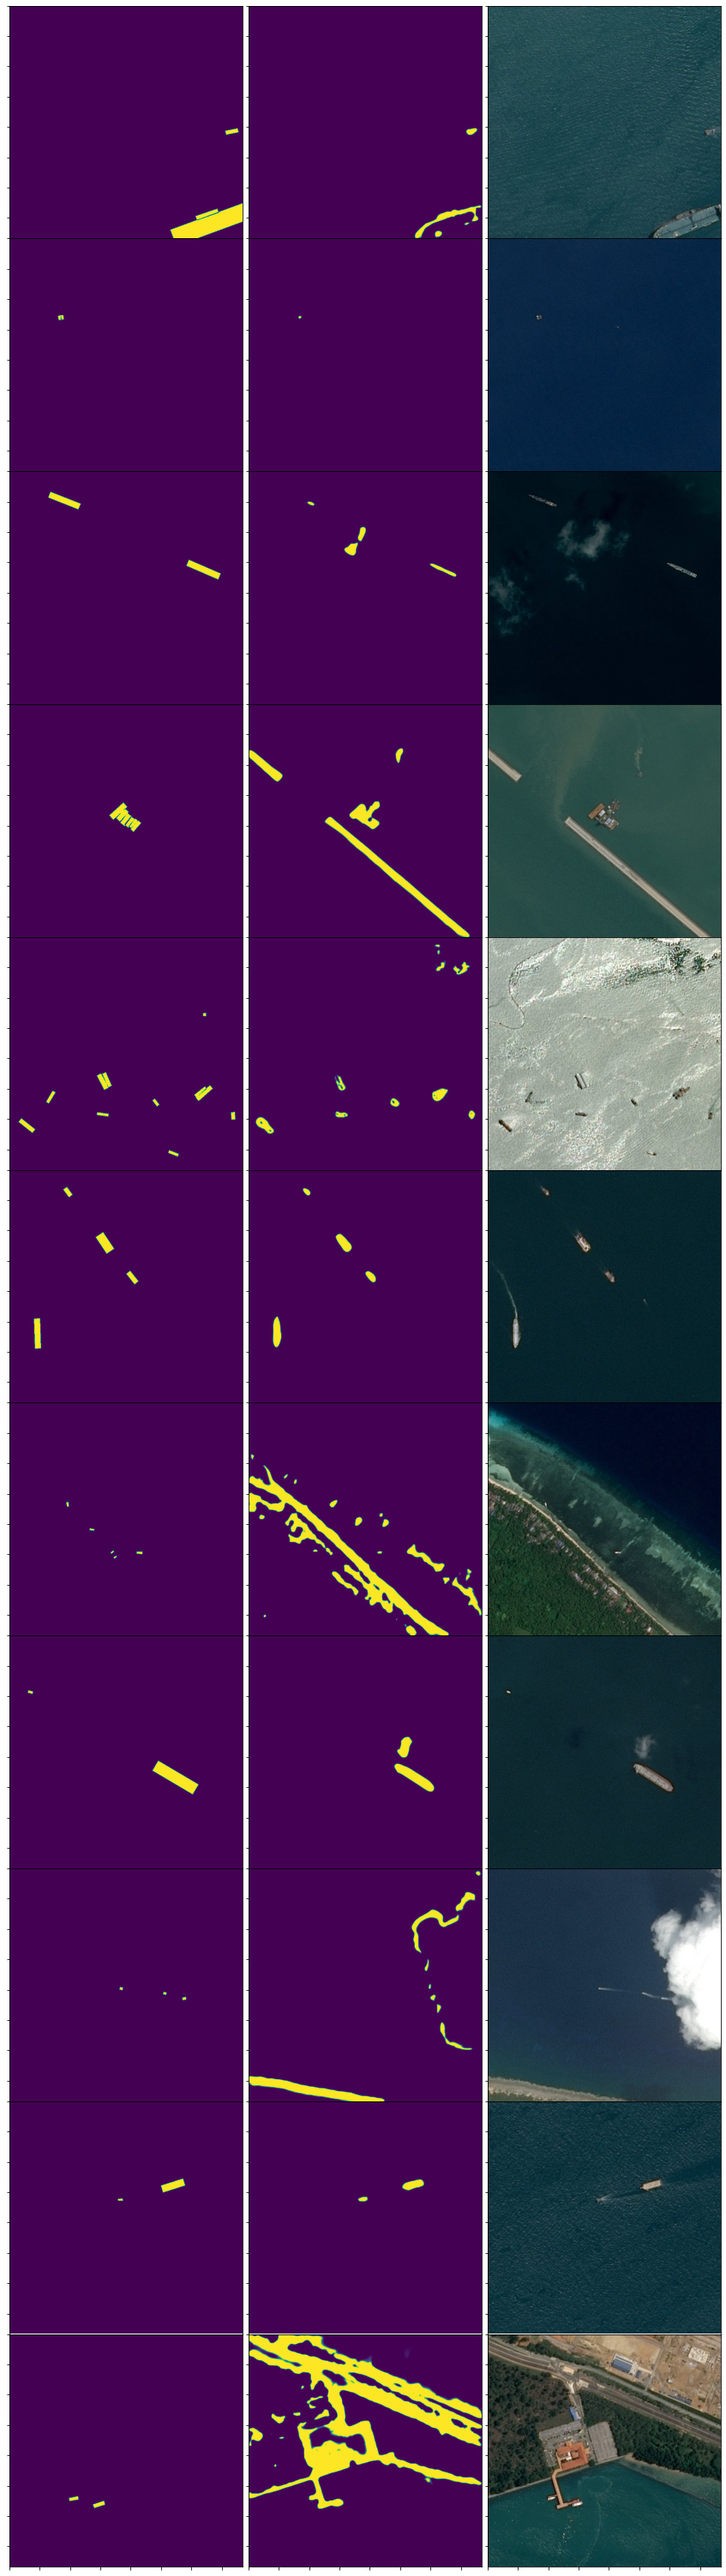

In [118]:
# LOAD FROM CHECKPOINT

# Create a new model instance
model_checkpoint = model9.unet(input_size = np.shape(X_train)[1:])
# Restore the weights
model_checkpoint.load_weights('checkpoints_v19.out')
#m_checkpoint = m.load_weights("checkpoints_v14.out")

images = ['80f68abdb.jpg',
'311e90084.jpg',
'1402afcf8.jpg',
'f2a5fddec.jpg',
'a71d6f9e7.jpg',
'76b5f333c.jpg',
'7b9e0e43c.jpg',
'1bee031fb.jpg',
'0dacba86d.jpg',
'e3b18ae46.jpg',
'893df42ad.jpg']

#test_gen = image_gen(df_test[df_test['count'] >= 2], print_name = True)
test_gen = image_gen(df_test[df_test['ImageId'].isin(images)], print_name = True)

fig = show_predictions(model_checkpoint, 11, test_gen)
fig.savefig('model1_output.png', bbox_inches = 'tight')



In [19]:
df_hist = pd.read_csv('log_v19.out', sep = ";")
df_hist



epoch  binary_accuracy  dice_coef      loss  true_positive_rate  \
0      0         0.932678   0.166497 -0.166241            0.388681   
1      1         0.962967   0.293986 -0.293761            0.607244   
2      2         0.969481   0.311653 -0.311411            0.626386   

   val_binary_accuracy  val_dice_coef  val_loss  val_true_positive_rate  
0             0.933164       0.397905 -0.482636                     NaN  
1             0.968023       0.513853 -0.535161                     NaN  
2             0.948741       0.464989 -0.360656                     NaN

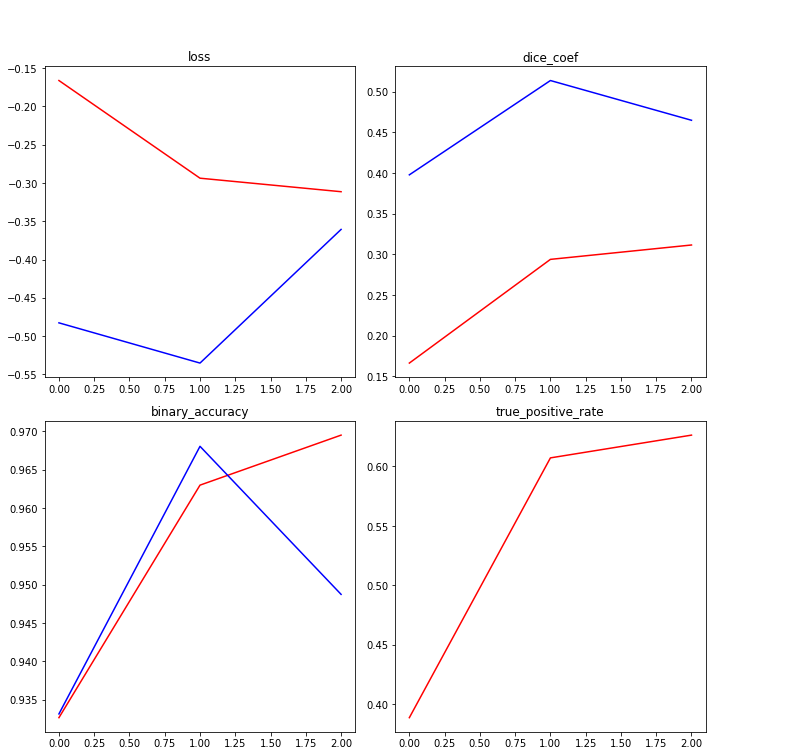

In [64]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize = (10,10))
ax1.plot(df_hist['loss'], label = 'training', c = 'red')
ax1.plot(df_hist['val_loss'], label = 'validation', c = 'blue')
ax1.set_title('loss')
#ax1.legend()

ax2.plot(df_hist['dice_coef'], label = 'training', c = 'red')
ax2.plot(df_hist['val_dice_coef'], label = 'validation', c = 'blue')
ax2.set_title('dice_coef')

#ax2.legend()

ax3.plot(df_hist['binary_accuracy'], label = 'training', c = 'red')
ax3.plot(df_hist['val_binary_accuracy'], label = 'validation', c = 'blue')
ax3.set_title('binary_accuracy')
#ax3.legend()

ax4.plot(df_hist['true_positive_rate'], label = 'training', c = 'red')
ax4.plot(df_hist['val_true_positive_rate'], label = 'validation', c = 'blue')
ax4.set_title('true_positive_rate')

plt.tight_layout()
fig.legend(['training', 'validation'], loc = (1,1))
fig.savefig('model1_convergence.png')
#ax4.legend()
#fig.legend(['training', 'validation'])# bbox_to_anchor=(0.9,0.8))


In [90]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=2, cols=2,
                   subplot_titles=("loss", "dice_coeff",
                                   "binary_accuracy", "true_positive_rate"),
                   vertical_spacing=0.1,
                   horizontal_spacing=0.1)

fig.add_trace(go.Scatter(y=df_hist['loss'], name='training',
                         marker = {'color' : 'red'}),row=1, col=1)
fig.add_trace(go.Scatter(y=df_hist['val_loss'], name='validation',
                         marker = {'color' : 'blue'}),row=1, col=1)

fig.add_trace(go.Scatter(y=df_hist['dice_coef'], marker = {'color' : 'red'},
                         showlegend=False),row=1, col=2)
fig.add_trace(go.Scatter(y=df_hist['val_dice_coef'], marker = {'color' : 'blue'},
                         showlegend = False),row=1, col=2)

fig.add_trace(go.Scatter(y=df_hist['binary_accuracy'], marker = {'color' : 'red'},
                         showlegend=False),row=2, col=1)
fig.add_trace(go.Scatter(y=df_hist['val_binary_accuracy'], marker = {'color' : 'blue'},
                         showlegend = False),row=2, col=1)

fig.add_trace(go.Scatter(y=df_hist['true_positive_rate'], marker = {'color' : 'red'},
                         showlegend=False),row=2, col=2)
fig.add_trace(go.Scatter(y=df_hist['val_true_positive_rate'], marker = {'color' : 'blue'},
                         showlegend = False),row=2, col=2)

fig.update_layout(title_text="Model Convergence",
                 margin=dict(l=0, r=0, t=50, b=0))
fig.write_html('model_1_convergence.html', include_plotlyjs = 'cdn')

In [ ]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize = (10,10))
ax1.plot(df_hist['loss'], label = 'training', c = 'red')
ax1.plot(df_hist['val_loss'], label = 'validation', c = 'blue')
ax1.set_title('loss')
#ax1.legend()

ax2.plot(df_hist['dice_coef'], label = 'training', c = 'red')
ax2.plot(df_hist['val_dice_coef'], label = 'validation', c = 'blue')
ax2.set_title('dice_coef')

#ax2.legend()

ax3.plot(df_hist['binary_accuracy'], label = 'training', c = 'red')
ax3.plot(df_hist['val_binary_accuracy'], label = 'validation', c = 'blue')
ax3.set_title('binary_accuracy')
#ax3.legend()

ax4.plot(df_hist['true_positive_rate'], label = 'training', c = 'red')
ax4.plot(df_hist['val_true_positive_rate'], label = 'validation', c = 'blue')
ax4.set_title('true_positive_rate')

plt.tight_layout()
fig.legend(['training', 'validation'], loc = (1,1))
fig.savefig('model1_convergence.png')

ModuleNotFoundError: No module named 'plotly'

Predicting 0 of 8
80f68abdb.jpg
Predicting 1 of 8
311e90084.jpg
Predicting 2 of 8
c23d9ec7e.jpg
Predicting 3 of 8
83176c994.jpg
Predicting 4 of 8
1402afcf8.jpg
Predicting 5 of 8
3153e53de.jpg
Predicting 6 of 8
73ec7b6a0.jpg
Predicting 7 of 8
8f65e8b8a.jpg


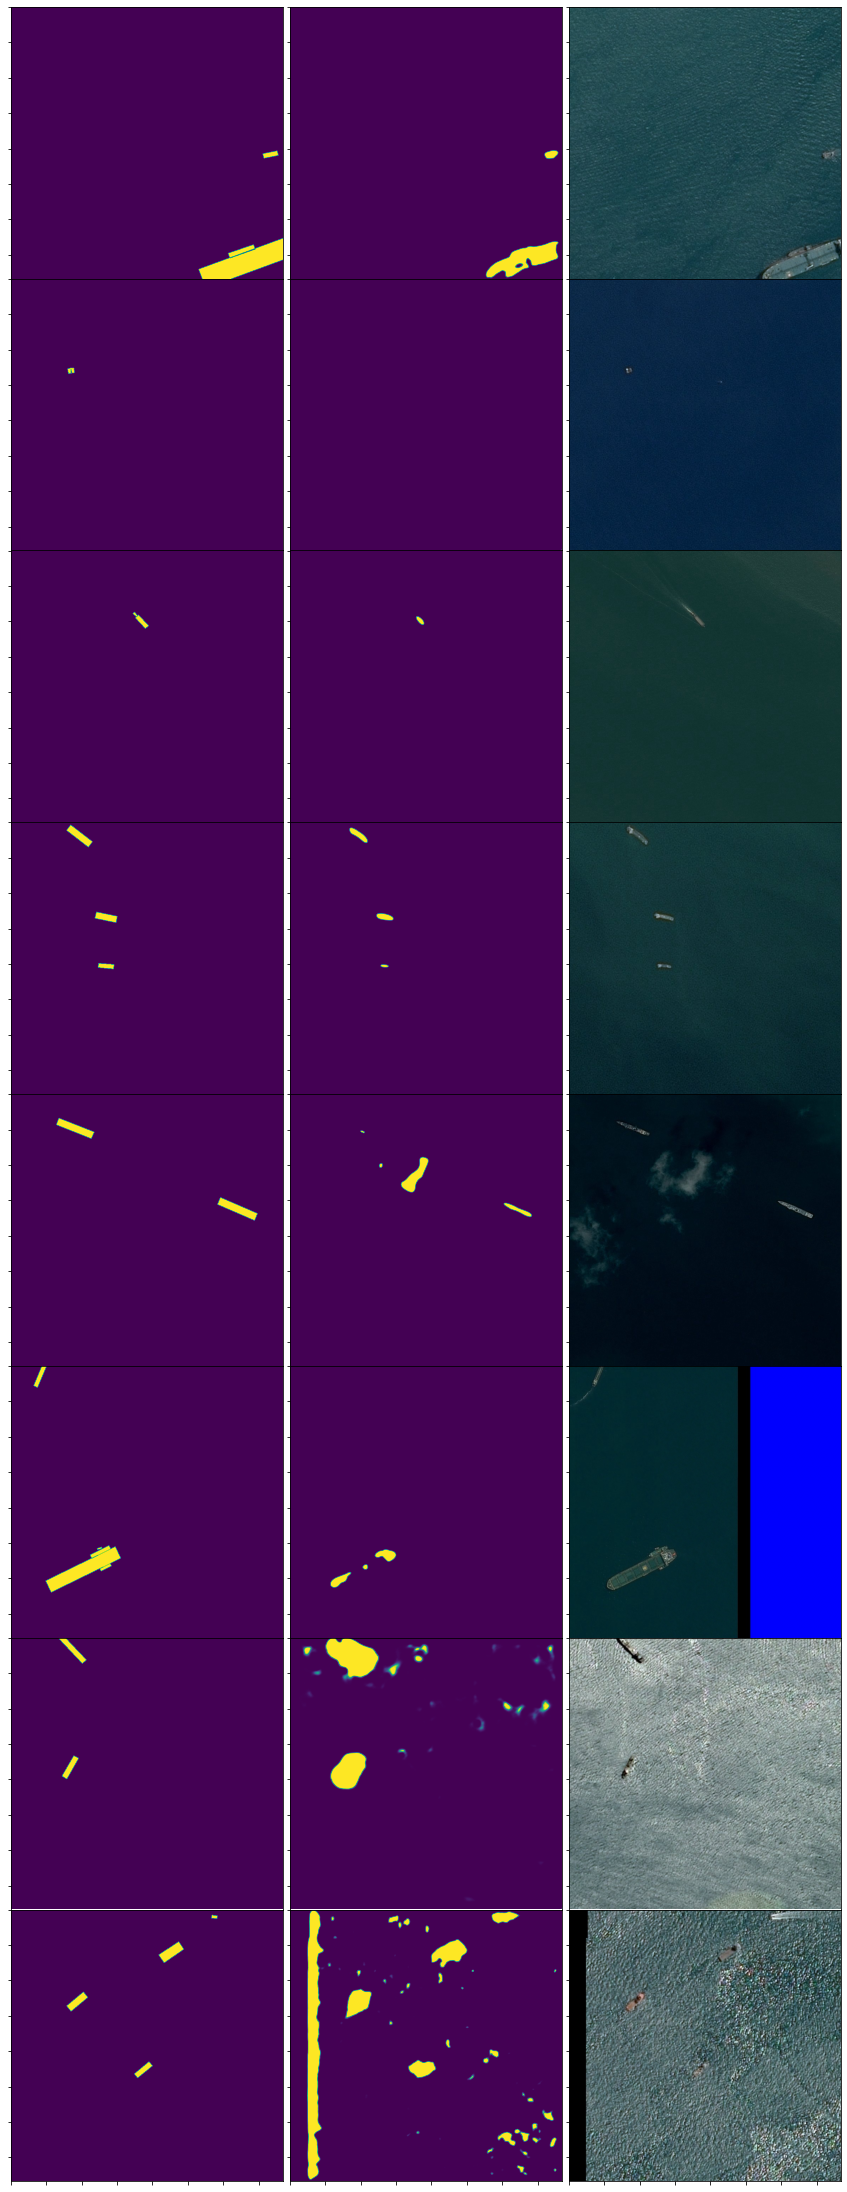

In [17]:
# LOAD FROM SAVED MODEL

from keras import models
import model2

# later try importing from model2
import keras.backend as K
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

# check that model was saved properly
mload = models.load_model('Model_v15.h5',
                      custom_objects = {'dice_p_bce' : dice_p_bce,
                                        'dice_coef' : dice_coef,
                                        'true_positive_rate' : true_positive_rate})


test_gen = image_gen(df_test[df_test['count'] >= 2], print_name = True)

show_predictions(mload, 8, test_gen)

In [ ]:
test_pred2 = model_checkpoint.predict(valid_x)
#fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (10,20))
#ax1.imshow(np.reshape(valid_y,(768,768)))
#ax2.imshow(np.reshape(test_pred2[0],(768,768)))
#3ax3.imshow(valid_x[0])

In [ ]:
show_predictions(model_checkpoint, 10, test_gen)

In [ ]:
#print(results7.history)
#dir(results7)

def plot_hist(results):
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize = (20,20))
    ax1.plot(results.history['loss'], label = 'loss')
    ax1.plot(results.history['val_loss'], label = 'val_loss')
    ax1.set_title('loss')
    
    ax2.plot(results.history['dice_coef'])
    ax2.plot(results.history['val_dice_coef'])
    ax2.set_title('dice_coef')
    
    ax3.plot(results.history['binary_accuracy'])
    ax3.plot(results.history['val_binary_accuracy'])
    ax3.set_title('binary_accuracy')
    
    ax4.plot(results.history['true_positive_rate'])
    ax4.plot(results.history['val_true_positive_rate'])
    ax4.set_title('true_positive_rate')

    
plot_hist(results10)